In [4]:
#### ENSEMBLE LEARNING AND RANDOM FORESTS ####

In [5]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [6]:
# A very simple way to create an even better classifier is to aggregate the predictions of
# each classifier and predict the class that gets the most votes. 
# This majority-vote classifier is called a hard voting classifier

In [7]:
### VOTING CLASSIFIERS ###

In [8]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

Saving figure law_of_large_numbers_plot


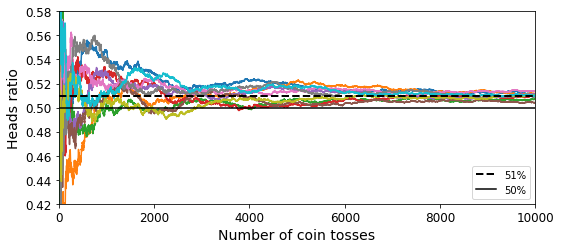

In [9]:
# The law of large numbers
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

In [10]:
# Let's use the moons dataset
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [11]:
from sklearn.ensemble import VotingClassifier
# VotingClassifier = use different training algorithms (different models) on the same dataset
# 3 models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

# Hard voting
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [12]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [13]:
# Let's look at each classifier's accuracy on the test set
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


In [14]:
# Soft voting (the same 3 models)
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [15]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


In [16]:
## BAGGING AND PASTING ##

In [17]:
# The following code trains an ensemble of 500 Decision Tree classifiers
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# BaggingClassifier = use the same training algorithm (same model), but on different training subsets
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [18]:
from sklearn.metrics import accuracy_score

# Accuracy for the ensemble
print(accuracy_score(y_test, y_pred))

0.904


In [19]:
# Accuracy for only one model
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [20]:
# A single Decision Tree (left) versus a bagging ensemble of 500 trees (right)
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Saving figure decision_tree_without_and_with_bagging_plot


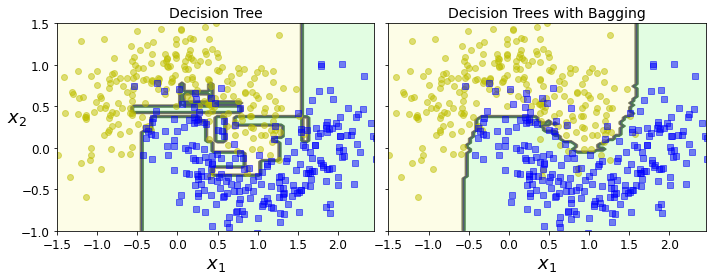

In [21]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

In [22]:
## OUT-OF-BAG EVALUATION ##

In [23]:
# With bagging, some instances may be sampled several times for any given predictor,
# while others may not be sampled at all. By default a BaggingClassifier samples m
# training instances with replacement (bootstrap=True), where m is the size of the
# training set. This means that only about 63% of the training instances are sampled on
# average for each predictor
# The remaining 37% of the training instances that are not
# sampled are called out-of-bag (oob) instances. Note that they are not the same 37%
# for all predictors.

# Since a predictor never sees the oob instances during training, it can be evaluated on
# these instances, without the need for a separate validation set. You can evaluate the
# ensemble itself by averaging out the oob evaluations of each predictor

In [24]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [25]:
# According to this oob evaluation, this BaggingClassifier is likely to achieve about
# 89.8% accuracy on the test set. Let’s verify this (91.2% - close enough)

from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

In [26]:
bag_clf.oob_decision_function_.shape

(375, 2)

In [27]:
bag_clf.oob_decision_function_
# The oob evaluation estimates that the first training
# instance has a 67.72% probability of belonging to the positive class (and 32.27% of
# belonging to the negative class):

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

In [28]:
### RANDOM PATCHES AND RANDOM SUBSPACES ###

In [29]:
# The BaggingClassifier class supports sampling the features as well. This is con‐
# trolled by two hyperparameters: max_features and bootstrap_features. They work
# the same way as max_samples and bootstrap, but for feature sampling instead of
# instance sampling. Thus, each predictor will be trained on a random subset of the
# input features. This is particularly useful when you are dealing with high-dimensional inputs (such as images).

In [30]:
### RANDOM FORESTS ###

In [31]:
# Instead of building a BaggingClassifier and passing it a DecisionTreeClassifier,
# you can instead use the RandomForestClassifier class, which is more convenient and optimized for Decision Trees

# BaggingClassifier is usefull if you want a bag of something other than Decision Trees

In [32]:
# The following code trains a Random Forest classifier with 500 trees 
# (each limited to maximum 16 leaf nodes), using all available CPU cores:

from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [33]:
# A Random Forest is equivalent to a bag of decision trees
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)

In [34]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [35]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # very similar predictions

1.0

In [36]:
## FEATURE IMPORTANCE ##

In [37]:
from sklearn.datasets import load_iris
iris = load_iris()

rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])

for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [38]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

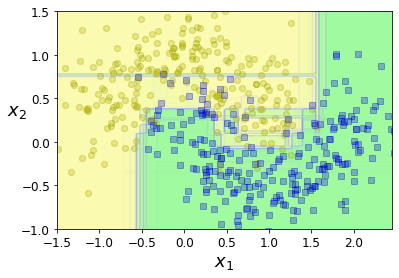

In [39]:
# The following figure overlays the decision boundaries of 15 decision trees.
# As you can see, even though each decision tree is imperfect, the ensemble defines a pretty good decision boundary

plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42+i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X_train[indices_with_replacement], y_train[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

plt.show()

In [40]:
# MNIST pixel importance (according to a Random Forest classifier)
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [41]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [42]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot, interpolation="nearest")
    plt.axis("off")

Saving figure mnist_feature_importance_plot


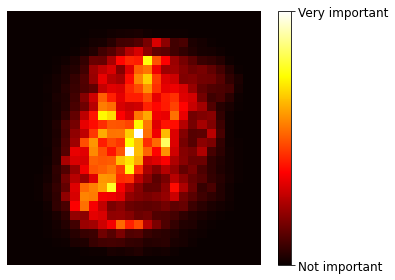

In [43]:
# plot each pixel’s importance
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

In [44]:
### BOOSTING ###

In [45]:
## ADA-BOOST ##

# One way for a new predictor to correct its predecessor is to pay a bit more attention
# to the training instances that the predecessor underfitted. This results in new predictors
# focusing more and more on the hard cases. This is the technique used by AdaBoost.

In [46]:
from sklearn.ensemble import AdaBoostClassifier

# DecisionTreeClassifier is the base estimator for AdaBoost
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

# If your AdaBoost ensemble is overfitting the training set, you can
# try reducing the number of estimators or more strongly regularizing the base estimator.

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

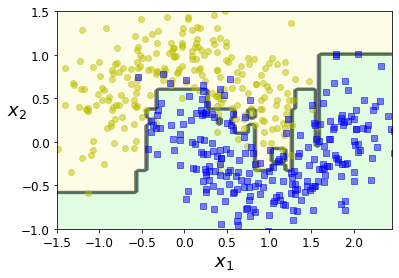

In [47]:
plot_decision_boundary(ada_clf, X, y)

Saving figure boosting_plot


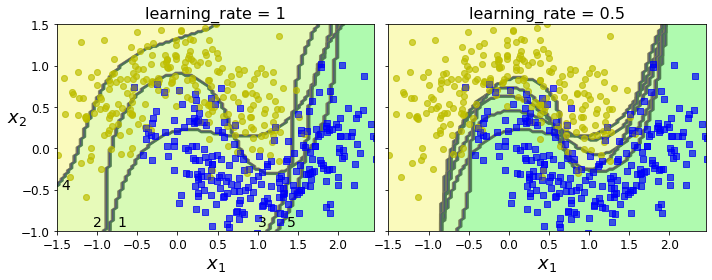

In [48]:
# Decision boundaries of consecutive predictors
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step

        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=14)
        plt.text(-1.05, -0.95, "2", fontsize=14)
        plt.text(1.0, -0.95, "3", fontsize=14)
        plt.text(-1.45, -0.5, "4", fontsize=14)
        plt.text(1.36,  -0.95, "5", fontsize=14)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

In [49]:
## GRADIENT BOOSTING ##

# Instead of tweaking the instance weights at every iteration like AdaBoost does,
# this method tries to fit the new predictor to the residual errors made by the previous predictor

In [50]:
# Let create a simple quadratic dataset
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)

In [51]:
# Now let's train the first decision tree regressor on this dataset
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [52]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [53]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [54]:
X_new = np.array([[0.8]])

In [55]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [56]:
y_pred

array([0.75026781])

In [57]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure gradient_boosting_plot


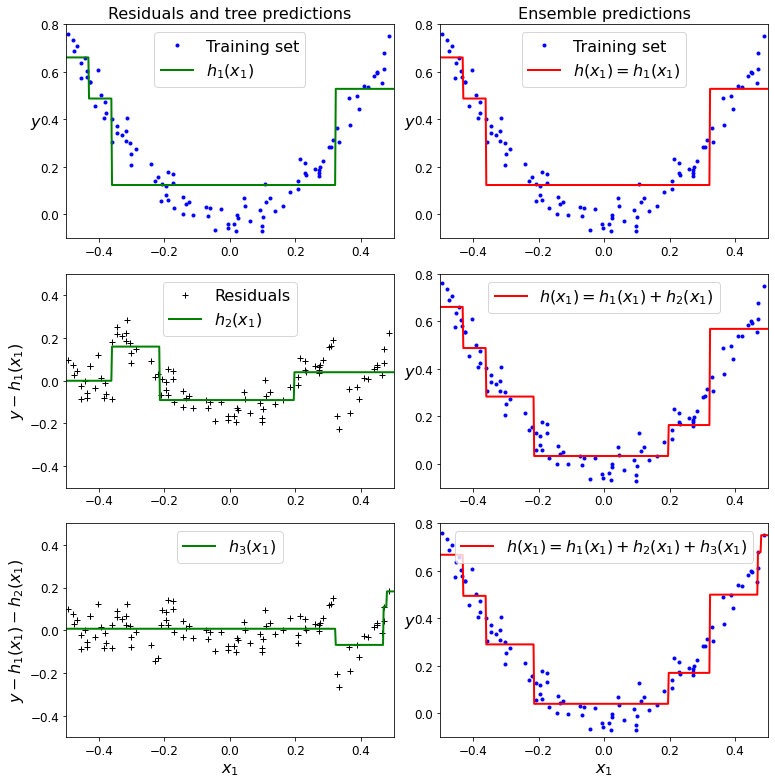

In [58]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

# In this example of Gradient Boosting, the first predictor (top left) is trained normally,
# then each consecutive predictor (middle left and lower left) is trained on the previous predictor’s residuals;
# the right column shows the resulting ensemble’s predictions

In [59]:
# Now let's try a gradient boosting regressor
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [60]:
# GBRT ensembles with not enough predictors (left) and too many (right)
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

Saving figure gbrt_learning_rate_plot


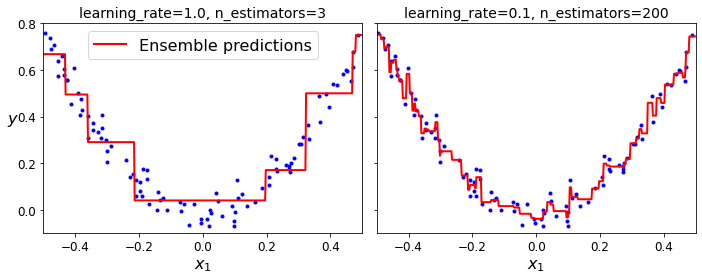

In [61]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

In [62]:
# In order to find the optimal number of trees, you can use early stopping.
# A simple way to implement this is to use the staged_predict() method.
# It returns an iterator over the predictions made by the ensemble at each stage of training (with one tree, two trees, etc.)

In [63]:
# The following code trains a GBRT ensemble with
# 120 trees, then measures the validation error at each stage of training to find the opti‐
# mal number of trees, and finally trains another GBRT ensemble using the optimal number of trees:

In [64]:
# Gradient Boosting with Early stopping

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

# Trains a GBRT ensemble with 120 trees
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1 
# np.argmin returns the index of the minimum error in the 'errors' array (+1 because is 0-indexing)
# the index of the minimum error = number of optimal trees for training a GBRT ensemble

# train another GBRT ensemble using a number of 'bst_n_estimators' trees
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

In [65]:
bst_n_estimators

56

In [66]:
# Tuning the number of trees using early stopping
min_error = np.min(errors)
min_error

0.002712853325235463

Saving figure early_stopping_gbrt_plot


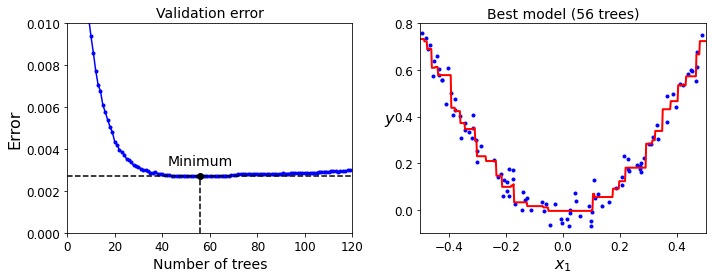

In [67]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

In [68]:
# It is also possible to implement early stopping by actually stopping training early
# (instead of training a large number of trees first and then looking back to find the
# optimal number). You can do so by setting warm_start=True, 
# which makes ScikitLearn keep existing trees when the fit() method is called, allowing incremental training.
# The following code stops training when the validation error does not improve for 5 iterations in a row

In [69]:
# warm_start=True for keeping existing trees when the fit() method is called
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0

for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators # train with 1 tree, 2 trees, 3 trees, etc.
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    
    # check if the error doesn't imporove
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5: # 5 iterations and the error didn't improve
            break  # early stopping

In [70]:
print(gbrt.n_estimators)

61


In [71]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


In [72]:
### EXERCISES ###

In [73]:
# 1. If you have trained 5 different models on the exact same training data, and
# they all achieve 95% precision, is there any chance that you can combine these
# models to get better results? If so, how? If not, why?

# You can combine these models into a voting ensemble to try to get better results.
# This works better on models that are very different, and trained on different training instances,
# but it will still work as long as the models are very different

In [74]:
# 2. What is the difference between hard and soft voting classifiers?

# Hard voting classifiers
# Counts the votes of each classifier in the ensemble and picks the class that gets the most votes

# Soft voting classifiers
# Computes the average estimated class probability for each class
# and picks the class with the highest probability. Gives high-confidence votes more weight,
# but only works if every classifier is able to estimate class probabilities

In [75]:
# 3. Is it possible to speed up training of a bagging ensemble by distributing it across
# multiple servers? What about pasting ensembles, boosting ensembles, random
# forests, or stacking ensembles?

# It is possible to speed up training of bagging, pasting, and random forests, 
# because each predictor is independent of the others.

# Boosting ensemble predictors are built based on the previous predictor, so separating training will not help.

# For stacking ensembles, all predictors for one layer has to be trained before the next layer

In [76]:
# 4. What is the benefit of out-of-bag evaluation?

# Each predictor in a bagging ensemble is evaluated using instances it was not trained on.
# This creates an unbiased eval of the ensemble without the need for a validation set.
# You can have more instances for training, and your ensemble can perform slightly better

In [77]:
# 5. What makes Extra-Trees more random than regular Random Forests? How can
# this extra randomness help? Are Extra-Trees slower or faster than regular Random Forests?

# Extra-Tree are more random than regular Radom Forests
# Extra-Trees use random thresholds (t_k) for each feature k,
# rather than searching for the best possible thresholds (like regular Decision Trees do)

# The extra randomness acts like a form of regularization and can be used to fix overfitting

# Extra-Trees are much faster to train than regular Random Forests since finding the best possible threshold for each
# feature at every node is one of the most time-consuming tasks of growing a tree
# The prediction time should be the same

In [78]:
# 6. If your AdaBoost ensemble underfits the training data, what hyperparameters should you tweak and how?

# If your AdaBoost ensemble underfits the training data, you can try increasing the number of estimators or 
# reducing the regularization hyperparameters of the base estimator. You may also try slightly increasing the learning rate

In [79]:
# 7. If your Gradient Boosting ensemble overfits the training set, should you increase or decrease the learning rate?

# If your Gradient Boosting ensemble overfits the training set, you should try decreasing the learning rate.
# You could also use early stopping to find the right number of predictors (you probably have too many)

In [80]:
# 8. Load the MNIST data (introduced in Chapter 3), and split it into a training set, a
# validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for val‐
# idation, and 10,000 for testing). Then train various classifiers, such as a Random
# Forest classifier, an Extra-Trees classifier, and an SVM. Next, try to combine
# them into an ensemble that outperforms them all on the validation set, using a
# soft or hard voting classifier. Once you have found one, try it on the test set. How
# much better does it perform compared to the individual classifiers?

In [81]:
# Loaded before
X = mnist["data"]

In [82]:
y = mnist["target"]

In [83]:
mnist["data"].shape

(70000, 784)

In [84]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, random_state=42)

In [85]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10000, random_state=42)

In [86]:
X_train.shape # 10k

(50000, 784)

In [87]:
X_test.shape # 10k

(10000, 784)

In [88]:
X_val.shape # 10k

(10000, 784)

In [89]:
# RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

rnd_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [90]:
y_pred_forest = rnd_forest_clf.predict(X_test)

In [91]:
from sklearn.metrics import accuracy_score

rnd_forest_clf_acc = accuracy_score(y_test, y_pred_forest)
rnd_forest_clf_acc

0.9645

In [92]:
# Extra-Trees
from sklearn.ensemble import ExtraTreesClassifier

extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
extra_trees_clf.fit(X_train, y_train)

ExtraTreesClassifier(random_state=42)

In [93]:
y_pred_extra_trees = extra_trees_clf.predict(X_test)

In [94]:
extra_trees_clf_acc = accuracy_score(y_test, y_pred_extra_trees)
extra_trees_clf_acc

0.9691

In [95]:
# SVM
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train, y_train)

SVC(random_state=42)

In [96]:
y_pred_svm_clf = svm_clf.predict(X_test)

In [97]:
svm_clf_acc = accuracy_score(y_test, y_pred_svm_clf)
svm_clf_acc

0.976

In [98]:
# Let's combine those 3 models into an ensemble
from sklearn.ensemble import VotingClassifier

eclf = VotingClassifier(estimators=[
    ('rf', rnd_forest_clf),
    ('extr', extra_trees_clf),
    ('svm', svm_clf),
    ], voting='hard')

eclf.fit(X_train, y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('extr', ExtraTreesClassifier(random_state=42)),
                             ('svm', SVC(random_state=42))])

In [99]:
y_pred_eclf = eclf.predict(X_val)

In [100]:
eclf_acc = accuracy_score(y_val, y_pred_eclf)
eclf_acc

0.9744

In [103]:
from sklearn.model_selection import GridSearchCV

eclf2 = VotingClassifier(estimators=[
        ('rf', RandomForestClassifier()),
        ('extr', ExtraTreesClassifier()),
        ('svm', SVC()),
        ], voting='soft')

params = {
    'rf__n_estimators': [75, 100, 125],
    'extr__n_estimators': [75, 100, 125],
    'svm__kernel': ['linear', 'poly', 'rbf'],
    'svm__C': [1, 2, 3],
}

grid_model = GridSearchCV(estimator=eclf2, param_grid=params, cv=2, verbose=2)

In [ ]:
# Takes a loooot of time
# grid_model.fit(X, y)

Fitting 2 folds for each of 81 candidates, totalling 162 fits


In [ ]:
grid_model.best_params_

In [ ]:
y_pred_grid_model = grid_model.best_estimator_.predict(X_val)

In [ ]:
grid_model_acc = accuracy_score(y_val, y_pred_grid_model)
grid_model_acc